# Вычислительная математика

## Матрицы специального вида

## Распространенные типы матриц

Матрицы (или линейные операторы), которые возникают в приложениях, совсем не случайны и всегда имеют какую-то структуру:

1. Разреженные (sparse) матрицы: число ненулевых элементов $NNZ(A) \ll nm$

2. Ленточные (band) матрицы: ненулевые элементы только вблизи диагонали: $a_{ij} = 0, \; |i-j| > w$

3. Тёплицевы матрицы и циркулянты (периодические матрицы): 
$$a_{ij} = t_{i - j}$$ 
или 
$$C_{ij} = c_{i - j \mod n},$$


$$C = \begin{bmatrix} c_0 & c_1 & c_2 & c_3 \\
 c_3 & c_0 & c_1 & c_2 \\
 c_2 & c_3 & c_0 & c_1 \\
 c_1 & c_2 & c_3 & c_0 \\
 \end{bmatrix}.
 $$


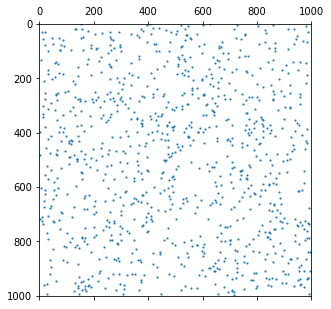

In [3]:
%matplotlib inline 
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
A = sparse.rand(1000,1000,0.001)
fig, ax = plt.subplots(figsize = (5,5))
ax.spy(A,ms = 1)

## Разреженные матрицы. Форматы

COO (Coordinate format): хранятся тройки $(i, j, a_{ij})$  
* Преимущества: простота создания матрицы, легкость добавления новых элементов. 
* Недостатки: сложно реализовать операции умножения на вектор, сложения матриц и index slicing (выделение подматрицы).

[scipy.sparse.coo\_matrix ](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html)




## Разреженные матрицы. Форматы

List of lists (LIL):  Хранится массив (list) массивов (строк), содержащих упорядоченные по возрастанию индексы столбцов ненулевых элементов и такой же массив, содержащий сами элементы матрицы.   
 * Преимущества: поддерживает index slicing , позволяет легко менять структуру разреженности (добавление/удаление ненулевого элемента). 
 * Недостатки: медленное сложение LIL + LIL и матрично-векторное умножение.

## Разреженные матрицы. Форматы

* CSR (Compressed Sparse Row): записываем элементы матрицы в массив по строкам. Задаётся 3-мя массивами:   
    * IA[0], IA[i] = IA[i-1] + *число NNZ в строке i-1* , $i = 1, m+1$, где $m$ - число строк  
    * A[k] , $k = 1, NNZ(A)$ - сами элементы матрицы
    * JA[k], $k = 1, NNZ(A)$ - индексы столбца для каждого элемента  

В этом формате удобно вычислять матричное умножение

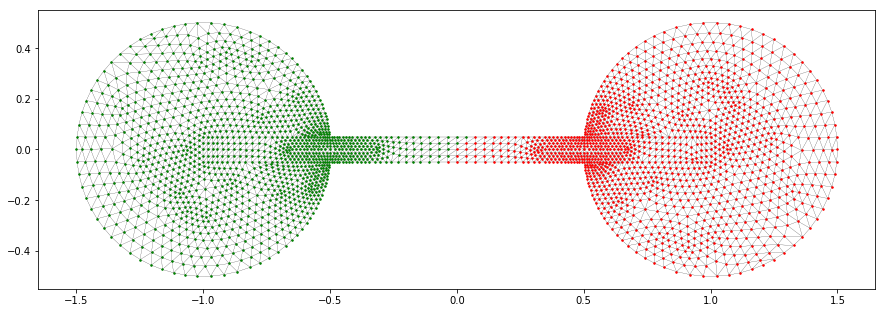

In [24]:
# For barbellgraph from MATLAB
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib as mpl
from matplotlib import collections  as mc

mpl.rcParams['figure.figsize'] = (15,15)

# read file with Laplacian matrix of graph; L = D - A
N = 2713
ii, jj, val = np.loadtxt('barbellgraph_adj.txt', dtype = 'int, int, float',unpack = True)
NNZ = ii.size
# Note " - 1" in indices: this is due to indices in file start from 1
ii = ii - 1
jj = jj - 1

# read file with (x,y) of each vertex
x, y = np.loadtxt('barbellgraph_xy.txt', unpack = True)

# plot graph
lines = []
for k in range(NNZ):
    lines.append([(x[ii[k]], y[ii[k]]), (x[jj[k]], y[jj[k]])])
lc = mc.LineCollection(lines, colors = 'k', linewidths = 0.1)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect('equal')
plt.savefig('barbellgraph.png', bbox_inches='tight', dpi = 150, format = 'png')

# Slow variant: try for comparison
# for k in range(0, np.size(ii)):
#     plt.plot([x[ii[k]], x[jj[k]]], [y[ii[k]], y[jj[k]]], 'b-', 'linewidth', 0.3)

# Create sparse Laplacian matrix
L = sps.coo_matrix((val, (ii,jj)), shape = (N, N))

# find 2 smallest eigenvalues and corresponding vectors
w, v = spsla.eigs(L, k = 2, which ='SM') 

U = v[:,1]
m = np.median(U)
ii1 = np.argwhere(U <= m)
ii2 = np.argwhere(U > m)
part = np.zeros(NNZ, dtype = 'int')
for k in range(ii1.size):
    part[ii1[k]] = 0

for k in range(ii2.size):
    part[ii2[k]] = 1

# plot partition
xx = []
yy = []
for k in range(ii1.size):
    xx.append(x[ii1[k]])
    yy.append(y[ii1[k]])
plt.plot(xx, yy, 'r.', ms = 3)

xx = []
yy = []
for k in range(ii2.size):
    xx.append(x[ii2[k]])
    yy.append(y[ii2[k]])
plt.plot(xx, yy, 'g.', ms = 3)

# plt.savefig('figures/spectral_partition.png', bbox_inches='tight', dpi = 300, format = 'png')

## Ленточные матрицы

* Пример: решение краевой задачи $u_{xx} = f(x), \; u(0) = u(1) = 0$
    * Введем сетку $x_i = i h, i = 0, \ldots, n+1, \quad h = 1/(n+1)$
    * Заменим производную 
    $$u_{xx} (x_i) \approx \frac{(u_{i+1} - 2u_{i} + u_{i-1})}{h^2}$$
    * Получим линейную систему:
    $$
    1 \times u_{i+1} - 2 \times u_{i} + 1 \times u_{i-1} = h^2 f(x_i) = h^2 f_i, \; i = 1, \ldots, n
    $$
    в матричном виде
    $$
    \left[\begin{array}{cccc}
    -2 & 1 &  &  \\
    1 & -2 & 1 &  \\
    & \ddots& \ddots& \ddots  \\
     & & 1 & -2 
    \end{array}\right] 
    \left[\begin{array}{c}
    u_1 \\
    u_2 \\
    \vdots \\
    u_n
    \end{array}\right] = 
    \left[\begin{array}{c}
    f_1 \\ f_2\\ \ldots \\ f_n
    \end{array}\right]
    $$

## Ленточные матрицы

* $LU$ разложение также будет ленточным
* Систему можно решить за $\mathcal{O}(nw^2)$, где $w$ - ширина ленты
* Решение с помощью $LU$ для трехдиагонального случая называют *метод прогонки* или Thomas algorithm
* Функция из scipy: [scipy.linalg.solve_banded](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html)

## Циркулянты. Преобразование Фурье

* непрерывное преобразование Фурье
$$
\hat{f}(\omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{+\infty} f(x) e^{-2 \pi i x \xi} \; dx
$$

* Дискретный аналог $f$ и $\hat{f}$ - векторы, берем значение гармоник на дискретной сетке

## Циркулянты

* Матрица преобразования Фурье (в каждом стобце гармоника $e^{-2\pi k t}$ на равномерной сетке)
$$
F_n =
\begin{pmatrix}
1 & 1 & 1 & \dots & 1 \\
1 & w^{1\cdot 1}_n & w^{1\cdot 2}_n & \dots & w^{1\cdot (n-1)}_n\\
1 & w^{2\cdot 1}_n & w^{2\cdot 2}_n & \dots & w^{2\cdot (n-1)}_n\\
\dots & \dots & \dots &\dots &\dots \\
1 & w^{(n-1)\cdot 1}_n & w^{(n-1)\cdot 2}_n & \dots & w^{(n-1)\cdot (n-1)}_n\\
\end{pmatrix},
$$
или
$$
F_n = \{ w_n^{kl} \}_{k,l=0}^{n-1},
$$
где $$w_n = e^{-\frac{2\pi i}{n}}.$$
* $F_n^{-1} = \frac{1}{N} F^*$

## Циркулянты
Свойства
* Симметричная
* Унитарная с точностью до множителя: $F_n^* F_n = F_n F_n^* = nI$ $F_n^{-1} = \frac{1}{n}F^*_n$
* Умножение на вектор можно вычислить за <font color='red'>$\mathcal{O}(n \log n)$</font> (быстрое преобразование Фурье)

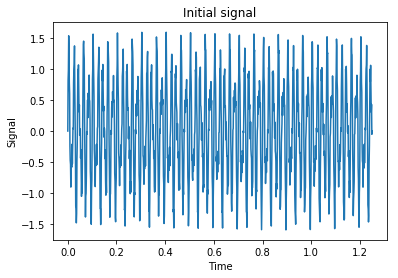

Text(0.5,1,'Discrete Fourier transform')

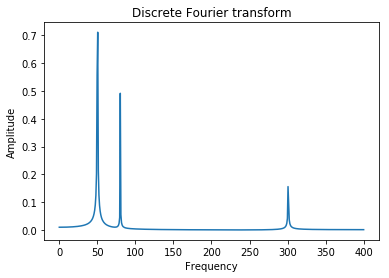

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


N = 1000
dt = 1.0 / 800.0
x = np.linspace(0.0, N*dt, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.2*np.sin(300.0 * 2.0*np.pi*x)
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Initial signal')
plt.show()
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2])) #Note: N/2 to N will give negative frequencies
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Discrete Fourier transform')

## Спектральная теорема для циркулянтов

**Теорема:**

Любая циркулянтная матрица может быть представлена в виде

$$C = \frac{1}{n} F^* \Lambda F,$$

где $F$ - **Матрица Фурье** 

$$F_{kl} = w_n^{kl}, \quad k, l = 0, \ldots, n-1, \quad w_n = e^{-\frac{2 \pi i}{n}},$$

и матрица $\Lambda = \text{diag}(\lambda)$ диагональная 

$$\lambda = F c, $$

где $c$ первый столбец $C$.